In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from skimage.filters import gaussian
from skimage.registration import phase_cross_correlation
from skimage.transform import EuclideanTransform, warp

In [ ]:
# data files selected:
# OK 2023_11_28 pAAA Tweez Pos 1
# OK 2023_12_06 pLPT20 Tweez Pos 4
# OK 2023_12_06 pLPT20 IPTG Tweez pos 11
# OK 2023_12_08 pLPT20 aTc Tweez pos 35
# OK 2023_12_04 pLPT107 Tweez pos 7
# OK 2023_12_04 pLPT107 IPTG Tweez pos 31
# OK 2023_12_08 pLPT107 aTc Ti Pos 14

In [39]:
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
folder_results = 'results'
folder_velocity = 'velocity_data'

scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}
plasmid_names = {'pLPT20&pLPT41': 'Repressilator single reporter', 
                 'pLPT119&pLPT41': 'Repressilator single reporter no deg tag', 
                 'pAAA': 'Triple constitutive reporter', 
                 'pLPT107&pLPT41': 'Repressilator triple reporter'}

exp_date = '2023_12_08'
#vector = 'pAAA'
#vector = 'pLPT20&pLPT41'
vector = 'pLPT107&pLPT41'

#chem = ''
#chem = 'IPTG'
chem = 'aTc'
scope_name = 'Ti scope'
pos = 14

path_scope = os.path.join(path_ext, scope_name)
path = os.path.join(path_scope, exp_date)
path_results = os.path.join(path,folder_results, f"pos{pos}")
path_velocity = os.path.join(path,folder_velocity, f"pos{pos}")

fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'

if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

fname

'2023_12_08_10x_1.0x_pLPT107&41_Ti_Pos14.ome.tif'

In [41]:
tf = 256
#tf = 216
edt = np.load(os.path.join(path_results,'edt.npy'))[:tf,:,:]
#edt = edt[:,:,:]

df = pd.read_excel('../data_processed.xlsx')
## preparing labels
df_pos = df[(df['Date'].dt.strftime('%Y_%m_%d') == exp_date) &
    (df.Machine == scope_name) &
    (df.DNA == vector) &
    (df.Position == pos)]

nt, nx, ny = edt.shape

## time labels
incub = df_pos['incub_time'].values[0]
#exp_length = df_pos['exp length'].values[0]
time_points = np.arange(0, nt)*10 + incub
time_strings = [f"{int(tp // 60):02d}" for tp in time_points]  # Show only hours
interval = 30
indices = np.arange(0, len(time_points), interval)
selected_time_strings = [time_strings[i] for i in indices]
## distance labels
ylim = edt.max() * df_pos['um_px'].values[0]
edt_max = edt.max(axis=(1,2))

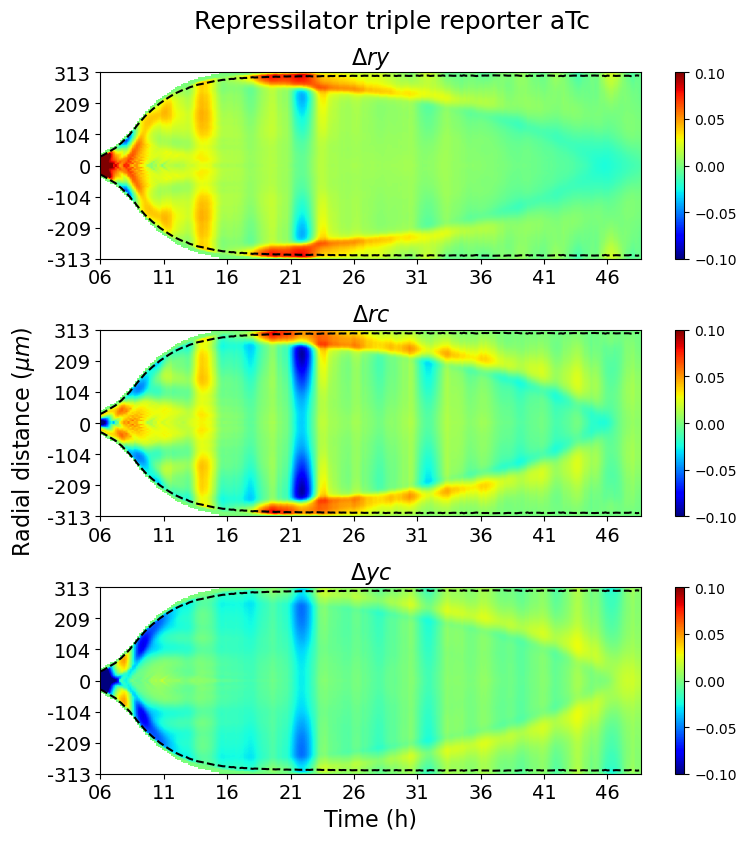

In [42]:
t0 = 0
wdlkymo_rho = np.load(os.path.join(path_results, 'wdlkymo_rho.npy'))[:tf,:,:]
um_px = df_pos['um_px'].values[0]
if fluo_chns == 2:
    fig, axs = plt.subplots(1, 1, figsize=(8, 3.5))
    # Plot Dyc
    im0 = axs.imshow(np.hstack([wdlkymo_rho[t0:,::-1,0],wdlkymo_rho[t0:,:,0]]).transpose(), 
                  aspect='auto', 
                  extent=[0, nt, -ylim, ylim],
                vmin=-0.1, vmax=0.1,
                cmap='jet')
    axs.plot(um_px*edt_max-5, 'k--')
    axs.plot(-um_px*edt_max+5, 'k--')
    axs.set_xlabel('Time (h)', fontsize=16)
    axs.set_ylabel('Radial distance ($\mu m)$', fontsize=14)
    axs.set_title('$\Delta{yc}$', fontsize=16)
    axs.set_xticks(indices)
    axs.set_xticklabels(selected_time_strings,fontsize=14)
    yticks = np.linspace(-ylim, ylim, num=7)
    axs.set_yticks(yticks)
    axs.set_yticklabels([f'{int(tick)}' for tick in yticks],fontsize=14)
    axs.figure.colorbar(im0, ax=axs)
    
    fig.suptitle(f'{plasmid_names[vector]} {chem}', fontsize=18)
    plt.tight_layout()
    plt.savefig(f'Ch4/delta_{vector}_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

    
if fluo_chns == 3:
    fig, axs = plt.subplots(3, 1, figsize=(8, 9))
    # Plot Dry
    im0 = axs[0].imshow(np.hstack([wdlkymo_rho[t0:,::-1,0],wdlkymo_rho[t0:,:,0]]).transpose(), 
                  aspect='auto', 
                  extent=[0, nt, -ylim, ylim],
                vmin=-0.1, vmax=0.1,
                cmap='jet')
    axs[0].plot(um_px*edt_max-10, 'k--')
    axs[0].plot(-um_px*edt_max+10, 'k--')
    #axs[0].set_xlabel('Time (h)', fontsize=14)
    #axs[0].set_ylabel('Radial distance ($\mu m)$', fontsize=12)
    axs[0].set_title('$\Delta{ry}$', fontsize=16)
    axs[0].set_xticks(indices)
    axs[0].set_xticklabels(selected_time_strings,fontsize=14)
    yticks = np.linspace(-ylim, ylim, num=7)
    axs[0].set_yticks(yticks)
    axs[0].set_yticklabels([f'{int(tick)}' for tick in yticks],fontsize=14)
    axs[0].figure.colorbar(im0, ax=axs[0])
    
    # Plot Drc
    im1 = axs[1].imshow(np.hstack([wdlkymo_rho[t0:,::-1,1],wdlkymo_rho[t0:,:,1]]).transpose(), 
                  aspect='auto', 
                  extent=[0, nt, -ylim, ylim],
                vmin=-0.1, vmax=0.1,
                cmap='jet')
    axs[1].plot(um_px*edt_max-10, 'k--')
    axs[1].plot(-um_px*edt_max+10, 'k--')
    #axs[1].set_xlabel('Time (h)', fontsize=14)
    #axs[1].set_ylabel('Radial distance ($\mu m)$', fontsize=12)
    axs[1].set_title('$\Delta{rc}$', fontsize=16)
    axs[1].set_xticks(indices)
    axs[1].set_xticklabels(selected_time_strings,fontsize=14)
    yticks = np.linspace(-ylim, ylim, num=7)
    axs[1].set_yticks(yticks)
    axs[1].set_yticklabels([f'{int(tick)}' for tick in yticks],fontsize=14)
    axs[1].figure.colorbar(im1, ax=axs[1])
    
    # Plot Dyc
    im2 = axs[2].imshow(np.hstack([wdlkymo_rho[t0:,::-1,2],wdlkymo_rho[t0:,:,2]]).transpose(), 
                  aspect='auto', 
                  extent=[0, nt, -ylim, ylim],
                vmin=-0.1, vmax=0.1,
                cmap='jet')
    axs[2].plot(um_px*edt_max-10, 'k--')
    axs[2].plot(-um_px*edt_max+10, 'k--')
    axs[2].set_xlabel('Time (h)', fontsize=16)
    #axs[2].set_ylabel('Radial distance ($\mu m)$', fontsize=12)
    axs[2].set_title('$\Delta{yc}$', fontsize=16)
    axs[2].set_xticks(indices)
    axs[2].set_xticklabels(selected_time_strings,fontsize=14)
    yticks = np.linspace(-ylim, ylim, num=7)
    axs[2].set_yticks(yticks)
    axs[2].set_yticklabels([f'{int(tick)}' for tick in yticks],fontsize=14)
    axs[2].figure.colorbar(im2, ax=axs[2])


    # Add shared x and y labels
    #plt.gcf().text(0.5, 0.04, 'Time (h)', ha='center', va='center', fontsize=16)
    plt.gcf().text(0.04, 0.5, r'Radial distance $(\mu m)$', ha='center', va='center', rotation='vertical', fontsize=16)
    
    #plt.savefig(f'Ch4/mean_fluo_{vector}_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    fig.suptitle(f'{plasmid_names[vector]} {chem}', fontsize=18)
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust layout to make room for the shared labels
    plt.savefig(f'Ch4/delta_{vector}_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

